/srv/home/xihua/Key_Product_Metrics
Generating Unique Devices chart...
Chart may not display with correct formatting in Jupyter Notebook window, check the charts/ folder for saved image...


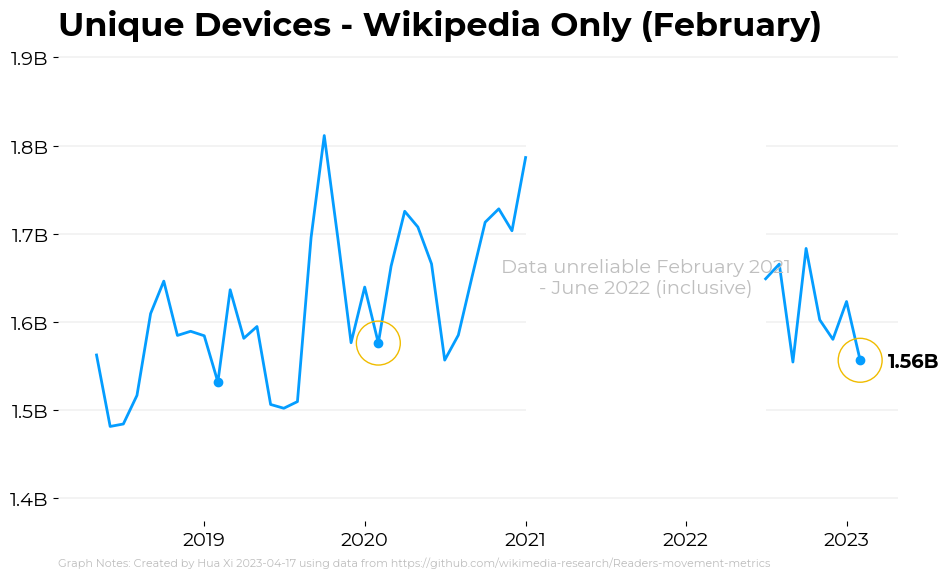

In [1]:
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from datetime import date, timedelta
import getopt
import sys
import os
from os.path import dirname
%cd ..
%run wikicharts.ipynb

def main():
    print("Generating Unique Devices chart...")

    #---SET PARAMETERS---
    #get current path
    home_dir = os.getcwd()
    outfile_name = "Unique_Devices.png"
    yoy_note = " "
    display_flag = False
    save_file_name = home_dir + "/charts/" + outfile_name

    #---CLEAN DATA--
    #read in data
    df = pd.read_csv(home_dir + '/resources/data/reader_metrics.tsv', sep='\t')

    start_date = "2018-05-01"
    end_date = datetime.datetime.today()
    month_interest = parameters['month_interest']

    #convert string to datetime
    df['month'] = pd.to_datetime(df['month'])

    #truncate to preferred date range
    df = df[df["month"].isin(pd.date_range(start_date, end_date))]

    #drop unneeded columns
    df = df.drop(columns=['automated_pageviews','desktop','interactions','mobileweb','previews_seen','total_pageview'])

    #drop rows w data error
    df_a = df[df["month"].isin(pd.date_range(start_date, "2021-01-01"))]
    df_b = df[df["month"].isin(pd.date_range("2022-07-01", end_date))]

    #monthly higlight
    monthly_df_a = df_a[df_a['month'].dt.month == month_interest]
    monthly_df_b = df_b[df_b['month'].dt.month == month_interest]
    monthly_df = pd.concat([monthly_df_a,monthly_df_b])

    #subset to highlight the last two months
    yoy_highlight = pd.concat([monthly_df.iloc[-2,:],monthly_df.iloc[-1,:]],axis=1).T

    #---PREPARE TO PLOT---
    chart = Wikichart(start_date,end_date,df)
    #adjust plot size
    fig, ax = plt.subplots()
    fig.set_figwidth(12)
    fig.set_figheight(6)
    plt.grid(axis = 'y', zorder=-1, color = wmf_colors['black25'], linewidth = 0.25)

    #---PLOT---
    #plot data
    #because of the break in the dataset, we don't use the wikichart class functions
    plt.plot(df_a.month, df_a.unique_devices,
        label='_nolegend_',
        color=wmf_colors['brightblue'],
        linewidth = 2,
        zorder=6)
    plt.plot(df_b.month, df_b.unique_devices,
        label='_nolegend_',
        color=wmf_colors['brightblue'],
        linewidth = 2,
        zorder=6)
    #draw circle on highlighted month by plotting scatter
    plt.scatter(monthly_df.month, monthly_df.unique_devices,
        label='_nolegend_',
        color=wmf_colors['brightblue'],
        zorder=7)
    highlight_radius = 1000000
    plt.scatter(yoy_highlight.month, yoy_highlight.unique_devices,
        label='_nolegend_',
        s=(highlight_radius**0.5),
        facecolors='none',
        edgecolors=wmf_colors['yellow'],
        zorder=8)

    #---DRAW DATA ERROR AREA---
    #create rectangle x coordinates
    startTime = datetime.datetime.strptime("2021-01-01", '%Y-%m-%d')
    endTime = datetime.datetime.strptime("2022-07-01", '%Y-%m-%d')

    # convert to matplotlib date representation
    xstart = mdates.date2num(startTime)
    xend = mdates.date2num(endTime)
    width = xend - xstart

    #get height
    ytick_values = plt.gca().get_yticks()
    ystart = ytick_values[0]
    height = ytick_values[-1] - ytick_values[0]

    # Plot rectangle
    rect = Rectangle((xstart, ystart), width, height, 
        color='white', 
        linewidth=0,
        #alpha=0.1,
        fill='white',
        #hatch='///',
        edgecolor=None,
        zorder=5)
        #fill=None,
    ax.add_patch(rect) 

    #rectangle annotation
    annotation_x = xstart + (width / 2)
    annotation_y = ystart + (height / 2)
    rectangle_text = "Data unreliable February 2021 - June 2022 (inclusive)"

    rectangle_textbox = ax.text(annotation_x, annotation_y, rectangle_text, 
        ha='center', 
        va='center', 
        color=wmf_colors['black25'],
        family='Montserrat',
        fontsize=14,
        wrap=True,
        bbox=dict(pad = 100, boxstyle='square', fc='none', ec='none'),
        zorder=8) 
    rectangle_textbox._get_wrap_line_width = lambda : 300.

    #---FORMATTING---
    chart.format(title = f'Unique Devices - Wikipedia Only',
        radjust=0.8,
        data_source="https://github.com/wikimedia-research/Readers-movement-metrics")
    chart.annotate(x='month',
        y='unique_devices',
        num_annotation=chart.calc_finalcount(y='unique_devices',yoy_note=yoy_note))
    
    print("Chart may not display with correct formatting in Jupyter Notebook window, check the charts/ folder for saved image...")
    chart.finalize_plot(save_file_name,display=display_flag)

if __name__ == "__main__":
    main()